In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from fairdata import FairData

In [3]:
# df_raw_1 = pd.read_excel('data/Fintech/Fintech-fairnessJun2020.xlsx', sheet_name='Approved&Default')
# df_raw_2 = pd.read_excel('data/Fintech/Fintech-fairnessJun2020.xlsx', sheet_name='Rejected')
df_raw_1['approved_dum'] = 1
df_raw_1['reward'] = (0.5-df_raw_1.def_flag) * 2
df_raw_2['approved_dum'] = 0
df_raw_2['reward'] = 0
df_tmp = pd.concat([
    df_raw_1.drop(['loan_transferred_date', 'def_flag'], axis=1),
    df_raw_2.rename(columns={'loan_request_initial_id': 'loan_request_id'}),
]).rename(columns={
    'noofconnections': 'connections',
    'noofapps': 'apps',
    'noofsms': 'sms',
    'noofcontacts': 'contacts',
}).astype({
    'customer_id': 'Int64',
    'loan_request_id': 'Int64',
    'age': 'float',
    'connections': 'float',
    'apps': 'float',
    'sms': 'float',
    'contacts': 'float',
    'approved_dum': 'Int64',
})
df_raw_3 = pd.read_csv('data/Fintech/Cashe_information.csv').rename(columns={
    'AGE': 'age',
}).astype({
    'customer_id': 'Int64',
    'loan_request_id': 'Int64',
    'age': 'float',
    'connections': 'float',
    'apps': 'float',
    'sms': 'float',
    'contacts': 'float',
    'approved_dum': 'Int64',
})
df_raw = pd.merge(
    df_tmp.dropna(),
    df_raw_3.loc[:, ['loan_request_id', 'salary', 'loan_amount', 'CIBIL']].dropna(), 
    how='left', on='loan_request_id').dropna()
df_raw

,customer_id,loan_request_id,age,connections,apps,sms,contacts,gender,approved_dum,reward,salary,loan_amount,CIBIL
0,150,218,32.0740,811.0,10.0,584.0,1820.0,m,1,1.0,40000.0,5000.0,707.0
1,150,97964,32.0740,811.0,10.0,584.0,1820.0,m,1,-1.0,40000.0,40000.0,707.0
2,150,66,32.0740,811.0,10.0,584.0,1820.0,m,1,1.0,40000.0,5000.0,707.0
3,150,2312,32.0740,811.0,10.0,584.0,1820.0,m,1,1.0,40000.0,5000.0,707.0
4,150,3754,32.0740,811.0,10.0,584.0,1820.0,m,1,1.0,40000.0,5000.0,707.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261924,1600000,282451,18.3178,1.0,24.0,121.0,171.0,m,0,0.0,115000.0,200000.0,747.0
261958,1600000,283249,30.0904,736.0,57.0,1638.0,862.0,m,0,0.0,50251.0,101000.0,663.0
261970,1600000,283473,18.6904,196.0,37.0,1328.0,203.0,m,0,0.0,68328.0,137000.0,745.0
261987,1600000,283850,27.9096,9.0,48.0,237.0,878.0,m,0,0.0,32012.0,64000.0,716.0


In [4]:
df_all = pd.merge(
    df_tmp[df_tmp.loan_request_id.notna()],
    df_raw_3.loc[df_raw_3.loan_request_id.notna(), ['loan_request_id', 'salary', 'loan_amount', 'CIBIL']], 
    how='left', on='loan_request_id')
df_all.shape

(400702, 13)

In [32]:
df_all.loc[:, ['age', 'gender', 'salary', 'loan_amount', 'CIBIL', 'connections', 'apps', 'sms', 'contacts']].std()

age                5.708215
salary         26522.746482
loan_amount    21879.939944
CIBIL            157.037339
connections      614.159298
apps              32.379692
sms             3840.340776
contacts        1293.016742
dtype: float64

In [39]:
(df_all.gender.dropna() == 'm').std()

0.2847832832901439

In [45]:
df_all.groupby(by='gender').mean()

,customer_id,loan_request_id,age,connections,apps,sms,contacts,approved_dum,reward,salary,loan_amount,CIBIL
gender,,,,,,,,,,,,
f,715471.954254,189589.325990,30.766147,324.654966,46.483850,2048.977352,608.748908,0.868782,0.779226,35299.189071,21426.118691,619.974225
m,733900.435070,195108.444003,31.721836,547.685489,54.019459,2372.446241,845.348248,0.874866,0.776375,37750.921527,22244.009628,634.257398


In [47]:
df_all.age.max()

59.6027

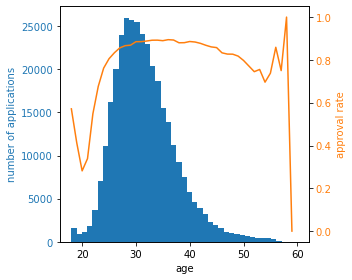

In [60]:
bins = pd.cut(df_all['age'], np.linspace(18, 60, 43))
mc = df_all['approved_dum'].groupby(by=bins).mean()
fig, ax1 = plt.subplots(figsize = (5, 4))
ax1.hist(df_all['age'], bins=43, range=(18,60))
ax1.set_xlabel('age')
ax1.set_ylabel('number of applications', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax2 = ax1.twinx()
ax2.plot(np.arange(18,60), mc, color='#ff7f0e')
ax2.set_ylabel('approval rate', color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')
fig.tight_layout()
plt.savefig('figure/approval_vs_age.pdf')

In [19]:
df_gender = df_raw[~df_raw.gender.isna()]
df_gender['gender_dum'] = 1
df_gender.loc[df_gender.gender == 'f', 'gender_dum'] = 0
df_gender = df_gender.drop('gender', axis=1).astype({'approved_dum': 'int64'})
df_gender

,customer_id,loan_request_id,age,connections,apps,sms,contacts,approved_dum,reward,salary,loan_amount,CIBIL,gender_dum
0,150,218,32.0740,811.0,10.0,584.0,1820.0,1,1.0,40000.0,5000.0,707.0,1
1,150,97964,32.0740,811.0,10.0,584.0,1820.0,1,-1.0,40000.0,40000.0,707.0,1
2,150,66,32.0740,811.0,10.0,584.0,1820.0,1,1.0,40000.0,5000.0,707.0,1
3,150,2312,32.0740,811.0,10.0,584.0,1820.0,1,1.0,40000.0,5000.0,707.0,1
4,150,3754,32.0740,811.0,10.0,584.0,1820.0,1,1.0,40000.0,5000.0,707.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261924,1600000,282451,18.3178,1.0,24.0,121.0,171.0,0,0.0,115000.0,200000.0,747.0,1
261958,1600000,283249,30.0904,736.0,57.0,1638.0,862.0,0,0.0,50251.0,101000.0,663.0,1
261970,1600000,283473,18.6904,196.0,37.0,1328.0,203.0,0,0.0,68328.0,137000.0,745.0,1
261987,1600000,283850,27.9096,9.0,48.0,237.0,878.0,0,0.0,32012.0,64000.0,716.0,1


In [21]:
df_o = pd.DataFrame({
    'cid':df_gender.customer_id,
    'lid':df_gender.loan_request_id,
    'gender':df_gender.gender_dum,
    'age':df_gender.age,
    'salary':df_gender.salary,
    'loan_amount':df_gender.loan_amount,
    'credit_score':df_gender.CIBIL,
    'connections':df_gender.connections,
    'contacts':df_gender.contacts,
    'messages':df_gender.sms,
    'apps':df_gender.apps,
    'action':df_gender.approved_dum,
    'reward':df_gender.reward,
})
df_o

,cid,lid,gender,age,salary,loan_amount,credit_score,connections,contacts,messages,apps,action,reward
0,150,218,1,32.0740,40000.0,5000.0,707.0,811.0,1820.0,584.0,10.0,1,1.0
1,150,97964,1,32.0740,40000.0,40000.0,707.0,811.0,1820.0,584.0,10.0,1,-1.0
2,150,66,1,32.0740,40000.0,5000.0,707.0,811.0,1820.0,584.0,10.0,1,1.0
3,150,2312,1,32.0740,40000.0,5000.0,707.0,811.0,1820.0,584.0,10.0,1,1.0
4,150,3754,1,32.0740,40000.0,5000.0,707.0,811.0,1820.0,584.0,10.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261924,1600000,282451,1,18.3178,115000.0,200000.0,747.0,1.0,171.0,121.0,24.0,0,0.0
261958,1600000,283249,1,30.0904,50251.0,101000.0,663.0,736.0,862.0,1638.0,57.0,0,0.0
261970,1600000,283473,1,18.6904,68328.0,137000.0,745.0,196.0,203.0,1328.0,37.0,0,0.0
261987,1600000,283850,1,27.9096,32012.0,64000.0,716.0,9.0,878.0,237.0,48.0,0,0.0


In [22]:
df_o.to_csv('fintech_fair_decision_making.csv')

In [2]:
df_raw_1 = pd.read_excel('data/Fintech/Fintech-fairnessJun2020.xlsx', sheet_name='Approved&Default')
df_raw_2 = pd.read_excel('data/Fintech/Fintech-fairnessJun2020.xlsx', sheet_name='Rejected')
df_raw_1['approved_dum'] = 1
df_raw_2['approved_dum'] = 0
df_tmp = pd.concat([
    df_raw_1.drop(['loan_transferred_date', 'def_flag'], axis=1),
    df_raw_2.rename(columns={'loan_request_initial_id': 'loan_request_id'}),
]).rename(columns={
    'noofconnections': 'connections',
    'noofapps': 'apps',
    'noofsms': 'sms',
    'noofcontacts': 'contacts',
}).astype({
    'customer_id': 'Int64',
    'loan_request_id': 'Int64',
    'age': 'float',
    'connections': 'float',
    'apps': 'float',
    'sms': 'float',
    'contacts': 'float',
    'approved_dum': 'Int64',
})
df_raw_3 = pd.read_csv('data/Fintech/Cashe_information.csv').rename(columns={
    'AGE': 'age',
}).astype({
    'customer_id': 'Int64',
    'loan_request_id': 'Int64',
    'age': 'float',
    'connections': 'float',
    'apps': 'float',
    'sms': 'float',
    'contacts': 'float',
    'approved_dum': 'Int64',
})
df_raw = pd.merge(
    df_tmp.dropna(),
    df_raw_3.loc[:, ['loan_request_id', 'salary', 'loan_amount', 'CIBIL']].dropna(), 
    how='left', on='loan_request_id').dropna()
df_raw

,customer_id,loan_request_id,age,connections,apps,sms,contacts,gender,approved_dum,salary,loan_amount,CIBIL
0,150,218,32.0740,811.0,10.0,584.0,1820.0,m,1,40000.0,5000.0,707.0
1,150,97964,32.0740,811.0,10.0,584.0,1820.0,m,1,40000.0,40000.0,707.0
2,150,66,32.0740,811.0,10.0,584.0,1820.0,m,1,40000.0,5000.0,707.0
3,150,2312,32.0740,811.0,10.0,584.0,1820.0,m,1,40000.0,5000.0,707.0
4,150,3754,32.0740,811.0,10.0,584.0,1820.0,m,1,40000.0,5000.0,707.0
...,...,...,...,...,...,...,...,...,...,...,...,...
261924,1600000,282451,18.3178,1.0,24.0,121.0,171.0,m,0,115000.0,200000.0,747.0
261958,1600000,283249,30.0904,736.0,57.0,1638.0,862.0,m,0,50251.0,101000.0,663.0
261970,1600000,283473,18.6904,196.0,37.0,1328.0,203.0,m,0,68328.0,137000.0,745.0
261987,1600000,283850,27.9096,9.0,48.0,237.0,878.0,m,0,32012.0,64000.0,716.0


In [3]:
del df_raw_1, df_raw_2, df_raw_3, df_tmp

In [4]:
df_gender = df_raw[~df_raw.gender.isna()]
df_gender['gender_dum'] = 1
df_gender.loc[df_gender.gender == 'f', 'gender_dum'] = 0
df_gender = df_gender.drop('gender', axis=1).astype({'approved_dum': 'int64'})
df_g = df_gender.drop(['customer_id', 'loan_request_id'], axis=1)
log_vars = ['loan_amount', 'salary', 'connections',  'apps', 'sms', 'contacts']
for c in log_vars:
    df_g[c] = np.log(df_g[c] + 1)
norm_vars = log_vars + ['age', 'CIBIL']
scaler = StandardScaler().fit(df_g[norm_vars])
df_g[norm_vars] = scaler.transform(df_g[norm_vars])

In [6]:
df_age = df_gender.copy()
df_age['age_dum'] = 1
df_age.loc[df_age.age < 28, 'age_dum'] = 0
df_a = df_age.drop(['customer_id', 'loan_request_id', 'age', 'CIBIL', 'loan_amount'], axis=1)
log_vars = ['salary', 'connections',  'apps', 'sms', 'contacts']
for c in log_vars:
    df_a[c] = np.log(df_a[c] + 1)
norm_vars = log_vars
scaler = StandardScaler().fit(df_a[norm_vars])
df_a[norm_vars] = scaler.transform(df_a[norm_vars])

In [7]:
df_b = df_a.copy()
df_b['dum'] = 0
df_b.loc[(df_b.age_dum == 0) & (df_b.gender_dum == 1), 'dum'] = 1
df_b.loc[(df_b.age_dum == 1) & (df_b.gender_dum == 0), 'dum'] = 2
df_b.loc[(df_b.age_dum == 1) & (df_b.gender_dum == 1), 'dum'] = 3
df_b

,connections,apps,sms,contacts,approved_dum,salary,gender_dum,age_dum,dum
0,0.742061,-2.373794,-0.045504,0.890059,1,0.432050,1,1,3
1,0.742061,-2.373794,-0.045504,0.890059,1,0.432050,1,1,3
2,0.742061,-2.373794,-0.045504,0.890059,1,0.432050,1,1,3
3,0.742061,-2.373794,-0.045504,0.890059,1,0.432050,1,1,3
4,0.742061,-2.373794,-0.045504,0.890059,1,0.432050,1,1,3
...,...,...,...,...,...,...,...,...,...
261924,-2.702040,-1.024403,-0.808190,-0.729581,0,2.584841,1,0,1
261958,0.686491,0.358826,0.455738,0.377513,0,0.897138,1,1,3
261970,-0.070057,-0.336196,0.353732,-0.612465,0,1.523554,1,0,1
261987,-1.779172,0.081672,-0.483064,0.390122,0,-0.022064,1,0,1


In [8]:
np.random.seed(1)

y = df_b.approved_dum.values.reshape(-1, 1)
s = df_b.dum.values.reshape(-1, 1)
a = df_b.drop(['approved_dum', 'age_dum', 'gender_dum', 'dum'], axis=1).values

n_test = 10000

shuffle_idx = np.arange(y.shape[0])
np.random.shuffle(shuffle_idx)
y_train, y_test = y[shuffle_idx[n_test:]], y[shuffle_idx[:n_test]]
s_train, s_test, s_eval = s[shuffle_idx[n_test:]], s[shuffle_idx[:n_test]], np.array([0, 1] * n_test).reshape(-1, 1)
a_train, a_test, a_eval = a[shuffle_idx[n_test:]], a[shuffle_idx[:n_test]], np.repeat(a[shuffle_idx[:n_test]], 2, axis=0)

In [8]:
df_b_fair_o = FairData(s_train, a_train, y_train, preprocess_method='o')
eval_o = df_b_fair_o.evaluate(a_test, s_test, y_test, ['cfb', 'cfbm', 'mae'], p_range=0.05, b=50)
pd.DataFrame(eval_o, index=['cfb', 'cfbm', 'mae'], columns=['ML', 'FTU', 'FL', 'AA', 'FLAP-1', 'FLAP-2'])

,ML,FTU,FL,AA,FLAP-1,FLAP-2
cfb,0.331591,0.201869,0.255536,0.253585,0.254412,0.255536
cfbm,0.161488,0.135045,0.132706,0.131944,0.131981,0.132706
mae,0.124886,0.126101,0.125834,0.126567,0.125835,0.125834


In [9]:
df_b_fair_m = FairData(s_train, a_train, y_train, preprocess_method='m')
eval_m = df_b_fair_m.evaluate(a_test, s_test, y_test, ['cfb', 'cfbm', 'mae'], p_range=0, b=1)
pd.DataFrame(eval_m, index=['cfb', 'cfbm', 'mae'], columns=['ML', 'FTU', 'FL', 'AA', 'FLAP-1', 'FLAP-2'])

,ML,FTU,FL,AA,FLAP-1,FLAP-2
cfb,0.125056,0.079382,0.097466,0.096308,0.050068,0.051186
cfbm,0.125056,0.079382,0.097466,0.096308,0.050068,0.051186
mae,0.124886,0.126101,0.125834,0.126567,0.125755,0.125772


In [10]:
df_b_fair_m = FairData(s_train, a_train, y_train, preprocess_method='m')
eval_m = df_b_fair_m.evaluate(a_test, s_test, y_test, ['cfbm'], p_range=0.025, b=25)
pd.DataFrame(eval_m, index=['cfbm'], columns=['ML', 'FTU', 'FL', 'AA', 'FLAP-1', 'FLAP-2'])

,ML,FTU,FL,AA,FLAP-1,FLAP-2
cfbm,0.145444,0.122257,0.11389,0.113289,0.105963,0.106668


In [11]:
df_b_fair_m = FairData(s_train, a_train, y_train, preprocess_method='m')
eval_m = df_b_fair_m.evaluate(a_test, s_test, y_test, ['cfbm'], p_range=0.05, b=50)
pd.DataFrame(eval_m, index=['cfbm'], columns=['ML', 'FTU', 'FL', 'AA', 'FLAP-1', 'FLAP-2'])

,ML,FTU,FL,AA,FLAP-1,FLAP-2
cfbm,0.1644,0.140052,0.135368,0.134602,0.121656,0.122709


In [12]:
df_b_fair_m = FairData(s_train, a_train, y_train, preprocess_method='m')
eval_m = df_b_fair_m.evaluate(a_test, s_test, y_test, ['cfbm'], p_range=0.1, b=100)
pd.DataFrame(eval_m, index=['cfbm'], columns=['ML', 'FTU', 'FL', 'AA', 'FLAP-1', 'FLAP-2'])

,ML,FTU,FL,AA,FLAP-1,FLAP-2
cfbm,0.165163,0.161043,0.156372,0.155815,0.138013,0.139021


In [15]:
df_b_fair_m = FairData(s_train, a_train, y_train, preprocess_method='m')
eval_m = df_b_fair_m.evaluate(a_test, s_test, y_test, ['cfbm'], p_range=1, b=100)
pd.DataFrame(eval_m, index=['cfbm'], columns=['ML', 'FTU', 'FL', 'AA', 'FLAP-1', 'FLAP-2'])

,ML,FTU,FL,AA,FLAP-1,FLAP-2
cfbm,0.286753,0.210861,0.234387,0.234547,0.232878,0.235421


In [11]:
df_b_fair_o = FairData(s_train, a_train, y_train, preprocess_method='o')
eval_o = df_b_fair_o.evaluate(
    a_test, s_test, y_test, metrics=['cfbm'], methods=['FLAP-1', 'FLAP-2'], p_range=0, b=1
)
pd.DataFrame(eval_o, index=['CFBM'], columns=['FLAP-1', 'FLAP-2'])

,FLAP-1,FLAP-2
CFBM,0.096377,0.097466


In [12]:
eval_o = df_b_fair_o.evaluate(
    a_test, s_test, y_test, metrics=['cfbm'], methods=['FLAP-1', 'FLAP-2'], p_range=0.025, b=25
)
pd.DataFrame(eval_o, index=['CFBM'], columns=['FLAP-1', 'FLAP-2'])

,FLAP-1,FLAP-2
CFBM,0.121756,0.122517


In [13]:
eval_o = df_b_fair_o.evaluate(
    a_test, s_test, y_test, metrics=['cfbm'], methods=['FLAP-1', 'FLAP-2'], p_range=0.1, b=100
)
pd.DataFrame(eval_o, index=['CFBM'], columns=['FLAP-1', 'FLAP-2'])

,FLAP-1,FLAP-2
CFBM,0.1465,0.147125


In [14]:
eval_o = df_b_fair_o.evaluate(
    a_test, s_test, y_test, metrics=['cfbm'], methods=['FLAP-1', 'FLAP-2'], p_range=1, b=100
)
pd.DataFrame(eval_o, index=['CFBM'], columns=['FLAP-1', 'FLAP-2'])

,FLAP-1,FLAP-2
CFBM,0.23617,0.23615


In [30]:
df_b_fair_m.cit_parametric(summary=True)

<F test: F=array([[25127.24149695]]), p=0.0, df_denom=1.94e+05, df_num=3>


0.0

In [59]:
p = df_b_fair_m.f_2(s_train, a_train, 'm')
y_hat = np.random.binomial(1, 0.95, len(y_train)).reshape(-1, 1)
df_b_processed = FairData(s_train, a_train, y_hat, preprocess_method='m')
df_b_processed.cit_parametric(summary=True)

<F test: F=array([[25759.31690959]]), p=0.0, df_denom=1.94e+05, df_num=3>


0.0